2025-02-12 20:22:51,886 [INFO] Found 2 images. Creating montage of the first 12 images.
I0000 00:00:1739388171.949439 3869911 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1739388171.991044 3948868 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1739388172.015466 3948879 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1739388172.130784 3869911 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1739388172.170043 3948886 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1739388172.193141 3948886 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inf

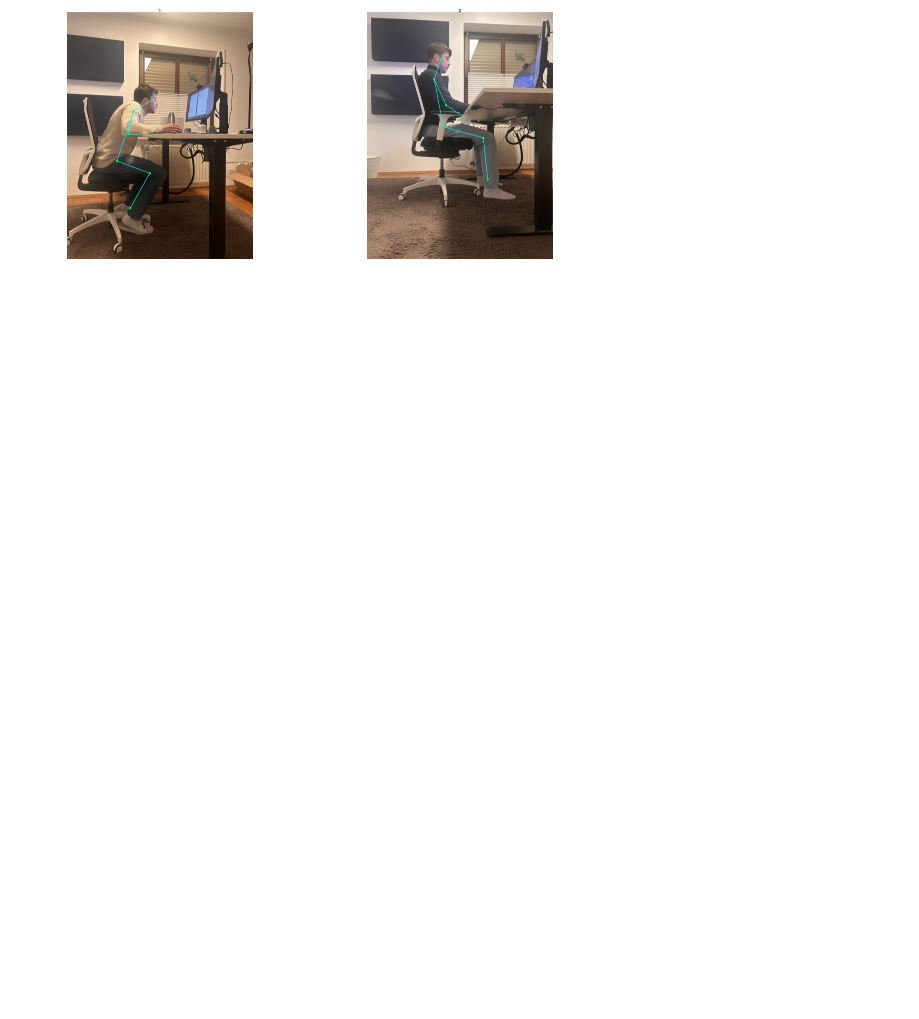

In [9]:
# EDA.py
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
from pose_estimation import extract_landmarks
from ui_tool import draw_relevant_landmarks_and_lines  # reuse your existing drawing function
import logging

logging.basicConfig(level=logging.INFO, format="%(asctime)s [%(levelname)s] %(message)s")


def load_and_annotate_image(image_path, seq_label):
    """
    Loads an image from image_path, runs landmark detection, draws landmarks and connecting lines,
    and adds a white margin at the top for a sequential label.

    The sequential label is drawn in larger font and centered horizontally.

    Returns the annotated image in RGB format.
    """
    # Read the image using OpenCV.
    image_bgr = cv2.imread(image_path)
    if image_bgr is None:
        logging.warning(f"Image {image_path} could not be loaded.")
        return None

    # Run landmark detection.
    landmarks, _, feedback = extract_landmarks(image_bgr, visualize=False)
    if landmarks is not None:
        # For EDA, we use the "left" side drawing.
        draw_relevant_landmarks_and_lines(image_bgr, landmarks, side='left')

    # Add a white margin at the top for the sequential label.
    h, w, _ = image_bgr.shape
    margin = 50  # pixels for the top margin
    annotated = cv2.copyMakeBorder(image_bgr, margin, 0, 0, 0,
                                   cv2.BORDER_CONSTANT, value=(255, 255, 255))

    # Prepare the text to be drawn.
    label_text = str(seq_label)
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 2.1  # larger font scale
    thickness = 6
    (text_width, text_height), baseline = cv2.getTextSize(label_text, font, font_scale, thickness)
    # Center the text horizontally.
    x = (w - text_width) // 2
    # Center the text vertically within the margin.
    y = (margin + text_height) // 2
    cv2.putText(annotated, label_text, (x, y), font, font_scale, (0, 0, 0), thickness, cv2.LINE_AA)

    # Convert the annotated image from BGR to RGB for display.
    annotated_rgb = cv2.cvtColor(annotated, cv2.COLOR_BGR2RGB)
    return annotated_rgb


def create_montage(image_paths, grid_cols=3, grid_rows=4):
    """
    Creates a montage of annotated images arranged in a grid.
    Only the first (grid_cols * grid_rows) images are used.
    """
    annotated_images = []
    num_images = grid_cols * grid_rows
    for idx, path in enumerate(image_paths[:num_images], start=1):
        annotated = load_and_annotate_image(path, seq_label=idx)
        if annotated is not None:
            annotated_images.append(annotated)

    total_images = len(annotated_images)
    # Create a figure with grid_rows x grid_cols subplots.
    fig, axes = plt.subplots(grid_rows, grid_cols, figsize=(grid_cols * 3, grid_rows * 2.5))

    # Remove all spacing around and between subplots.
    plt.subplots_adjust(left=0, right=1, top=1, bottom=0, wspace=0, hspace=0)

    axes = axes.flatten()
    for i, ax in enumerate(axes):
        if i < total_images:
            ax.imshow(annotated_images[i])
            ax.axis("off")
        else:
            ax.axis("off")

    plt.show()


if __name__ == "__main__":
    # Directory with raw images.
    raw_dir = os.path.join("..", "data", "raw_images")
    valid_exts = ('.jpg', '.jpeg', '.png')

    # Get list of valid image file paths.
    all_files = [os.path.join(raw_dir, f) for f in os.listdir(raw_dir)
                 if f.lower().endswith(valid_exts)]

    if not all_files:
        logging.error("No valid images found in the raw_images directory.")
    else:
        logging.info(f"Found {len(all_files)} images. Creating montage of the first 12 images.")
        create_montage(all_files, grid_cols=3, grid_rows=4)